# **Graph Neural Networks for End-to-End Particle Identification with the CMS Experiment Task-2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Requirements

In [4]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Libraries

In [2]:
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [1]:
# Modules for pytorch model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear, global_mean_pool, GraphConv, global_max_pool
import torch.nn.functional as F
from torch_cluster import knn_graph

## Model - PyTorch CNN

### Creating Custom Dataset

Graph Construction

1. Treat all 125x125 pixels as nodes of the graph.
2. Keep only the nodes having non-zero channel values. This helps convert the image to a point-cloud representation.
3. Now, for each node take the nearest k(=8) neigbours as the edge indices.
4. The node features are set as the channel values hence we get 3 features per node.

In [4]:
class MyDataset(Dataset):

    """
    Custom dataset for Image dataset. 
    Reads the dataset from the parquet file and constructs the graph by first converting into a point-cloud representation.
    k --> number of nearest neighbors.
    """

    def __init__(self, split = 'train', test_size = 0.2, k = 8):

      filename = '/content/drive/MyDrive/GSOC/Quark-gluon using cnn/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
      self.parquet_file = pq.ParquetFile(filename)
      self.k = k

      num_rows = self.parquet_file.metadata.num_rows

      # Reading dataset from the parquet file and performing 80/20 train-test split.
      indices = np.arange(num_rows)
      train, test = train_test_split(indices, test_size = test_size, stratify = np.array(self.parquet_file.read(columns = 'y')).reshape(-1))

      if split == 'train':
        data = self.parquet_file.read_row_groups(sorted(train), columns = ['X_jets', 'y'])
        self.X = torch.tensor(data.column('X_jets').to_pylist())
        self.y = torch.tensor(data.column('y').to_pylist()).long()
  
      else:
        data = self.parquet_file.read_row_groups(sorted(test), columns = ['X_jets', 'y'])
        self.X = torch.tensor(data.column('X_jets').to_pylist())
        self.y = torch.tensor(data.column('y').to_pylist()).long()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):

      return self.construct_graph(self.X[idx].permute(1,2,0), self.y[idx], self.k)

    def construct_graph(self, X, y, k):

      # create a 2D grid of x, y coordinates
      x_coords = torch.arange(0, 125)
      y_coords = torch.arange(0, 125)
      xx, yy = torch.meshgrid(x_coords, y_coords, indexing='xy')
      pos = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)

      # calculate the sum of absolute values of channels for each pixel
      abs_sum = torch.sum(torch.abs(X), dim=2).reshape(-1)

      # filter out coordinates with sum of absolute channel values as 0
      nonzero_coords = pos[abs_sum != 0]
      num_nodes = len(nonzero_coords)

      # create node features as 3 channel values for each pixel
      node_features = X.reshape(-1,3)[abs_sum != 0]

      # calculate edge indices based on the k-nearest neighbors graph
      
      edge_indices = knn_graph(nonzero_coords, k, loop=False)

      # create PyTorch Geometric data object
      data = Data(
          x=node_features,
          y=y,
          edge_index=edge_indices,
          pos=nonzero_coords)
      
      return data
  

In [5]:
train_dataset = MyDataset(split='train')
test_dataset = MyDataset(split='test')

### Data Loaders

In [6]:
def get_data_loaders(train_dataset, test_dataset, batch_size=32):

    """
    Function to create the DataLoaders for train-val-test data. 
    Can specify batch size. Default value is set to 32.
    """

    # Shuffle=True for training data to get diversity in batches at each training epoch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(train_dataset, test_dataset, batch_size=32)

Set Device

In [7]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device = get_device()
print(device)

cuda


### Model Architecture

I haved used 2 GNN architectures

**Architecture 1**

1. 3-layer GCN network with relu for aggregation of node-level features.
2. Readput layer as global mean pooling for graph-level embedding.
3. A dropout layer followed by linear layer.

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, node_features = 2, hidden_channels = 16, num_classes = 2):

        super(GCN, self).__init__()
        torch.manual_seed(1)

        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

**Architecture 2**

1. Use of GraphConv layer in-place of GCN layer. It adds skip connections in the network tp preserve central node information and omits neighborhood normalization completely.

2. The same readout layer with gloab_mean_pooling is used. I also tried using a combination of global_mean and global_max pool but it lead to decrease in performance.

3. This is followed by an additional linear layer with relu. Then a dropout and final linear layer.

In [10]:
class GraphNN(torch.nn.Module):
    def __init__(self, node_features = 2, hidden_channels = 16, num_classes = 2):

        super(GraphNN, self).__init__()
        torch.manual_seed(1)

        self.conv1 = GraphConv(node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)

        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Neighbourhood node-feature aggregation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # Batch-wise node-level aggreation 
        x = global_mean_pool(x, batch)  # (batch, features)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        return x

In [11]:
model_GCN = GCN(node_features = 3, hidden_channels = 16, num_classes = 2)
model_GraphNN = GraphNN(node_features = 3, hidden_channels = 16, num_classes = 2)

model_GCN = model_GCN.to(device)
model_GraphNN = model_GraphNN.to(device)

In [12]:
print(model_GCN)

GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [13]:
print(model_GraphNN)

GraphNN(
  (conv1): GraphConv(3, 16)
  (conv2): GraphConv(16, 16)
  (conv3): GraphConv(16, 16)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [14]:
# Defining the optimizer and loss function

optimizer_GCN = torch.optim.Adam(model_GCN.parameters(), lr=1e-3)
optimizer_GraphNN = torch.optim.Adam(model_GraphNN.parameters(), lr=1e-3)

scheduler_GCN = StepLR(optimizer_GCN, step_size=10, gamma=0.5)
scheduler_GraphNN = StepLR(optimizer_GraphNN, step_size=10, gamma=0.5)

criterion = torch.nn.CrossEntropyLoss()

### Defining Train-Val-Test Functions

In [15]:
def train(model, device, loader, optimizer, criterion, scheduler):

    model.train()
    correct = 0
    total_loss = 0
    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        
        data = data.to(device)

        out = model(data)  # Perform a single forward pass.

        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        pred = out.argmax(dim=1)

        correct += int((pred == data.y).sum())
        total_loss += loss.item()

    scheduler.step()
    lr = optimizer.param_groups[0]['lr']

    print(f'Train Acc: {correct/len(loader.dataset):.3f}, Train Loss: {total_loss:.4f}, Learning Rate: {lr:.6f}')

    return model, total_loss

    
def evaluate(model, device, loader):
  
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for data in tqdm(loader):

            data = data.to(device)
            out = model(data)

            # Calculation of correctly classified edges
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()

        print(f'Val Acc : {correct/len(loader.dataset):.3f}\n')

### Training

In [16]:
# Training Loop for Architecture 1

epochs = 10

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_GCN, loss = train(model_GCN, device, train_loader, optimizer_GCN, criterion, scheduler_GCN)
  evaluate(model_GCN, device, test_loader)

Epoch : 1 



100%|██████████| 907/907 [01:12<00:00, 12.58it/s]


Train Acc: 0.658, Train Loss: 572.7598, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.17it/s]


Val Acc : 0.690

Epoch : 2 



100%|██████████| 907/907 [01:11<00:00, 12.65it/s]


Train Acc: 0.687, Train Loss: 552.8842, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 12.99it/s]


Val Acc : 0.699

Epoch : 3 



100%|██████████| 907/907 [01:11<00:00, 12.65it/s]


Train Acc: 0.688, Train Loss: 549.2730, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.10it/s]


Val Acc : 0.693

Epoch : 4 



100%|██████████| 907/907 [01:11<00:00, 12.67it/s]


Train Acc: 0.691, Train Loss: 548.9173, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.10it/s]


Val Acc : 0.692

Epoch : 5 



100%|██████████| 907/907 [01:11<00:00, 12.66it/s]


Train Acc: 0.692, Train Loss: 547.6113, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.16it/s]


Val Acc : 0.697

Epoch : 6 



100%|██████████| 907/907 [01:10<00:00, 12.80it/s]


Train Acc: 0.697, Train Loss: 546.1634, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.04it/s]


Val Acc : 0.703

Epoch : 7 



100%|██████████| 907/907 [01:12<00:00, 12.50it/s]


Train Acc: 0.696, Train Loss: 542.5864, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 12.73it/s]


Val Acc : 0.704

Epoch : 8 



100%|██████████| 907/907 [01:12<00:00, 12.54it/s]


Train Acc: 0.704, Train Loss: 538.4123, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.06it/s]


Val Acc : 0.708

Epoch : 9 



100%|██████████| 907/907 [01:11<00:00, 12.68it/s]


Train Acc: 0.704, Train Loss: 538.4194, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.01it/s]


Val Acc : 0.698

Epoch : 10 



100%|██████████| 907/907 [01:11<00:00, 12.67it/s]


Train Acc: 0.704, Train Loss: 537.6170, Learning Rate: 0.000500


100%|██████████| 227/227 [00:17<00:00, 13.06it/s]

Val Acc : 0.685



In [17]:
# Training Loop for Architecture 2

epochs = 10

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_GraphNN, loss = train(model_GraphNN, device, train_loader, optimizer_GraphNN, criterion, scheduler_GraphNN)
  evaluate(model_GraphNN, device, test_loader)

Epoch : 1 



100%|██████████| 907/907 [01:10<00:00, 12.85it/s]


Train Acc: 0.613, Train Loss: 622.9462, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.33it/s]


Val Acc : 0.679

Epoch : 2 



100%|██████████| 907/907 [01:10<00:00, 12.78it/s]


Train Acc: 0.673, Train Loss: 561.4441, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.42it/s]


Val Acc : 0.661

Epoch : 3 



100%|██████████| 907/907 [01:10<00:00, 12.80it/s]


Train Acc: 0.688, Train Loss: 550.0447, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.44it/s]


Val Acc : 0.698

Epoch : 4 



100%|██████████| 907/907 [01:10<00:00, 12.90it/s]


Train Acc: 0.691, Train Loss: 545.1589, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.42it/s]


Val Acc : 0.700

Epoch : 5 



100%|██████████| 907/907 [01:11<00:00, 12.71it/s]


Train Acc: 0.694, Train Loss: 544.0537, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.30it/s]


Val Acc : 0.698

Epoch : 6 



100%|██████████| 907/907 [01:11<00:00, 12.65it/s]


Train Acc: 0.697, Train Loss: 542.3660, Learning Rate: 0.001000


100%|██████████| 227/227 [00:17<00:00, 13.35it/s]


Val Acc : 0.706

Epoch : 7 



100%|██████████| 907/907 [01:11<00:00, 12.77it/s]


Train Acc: 0.699, Train Loss: 540.5569, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.44it/s]


Val Acc : 0.704

Epoch : 8 



100%|██████████| 907/907 [01:10<00:00, 12.81it/s]


Train Acc: 0.696, Train Loss: 541.6637, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.46it/s]


Val Acc : 0.707

Epoch : 9 



100%|██████████| 907/907 [01:10<00:00, 12.90it/s]


Train Acc: 0.698, Train Loss: 539.4370, Learning Rate: 0.001000


100%|██████████| 227/227 [00:16<00:00, 13.41it/s]


Val Acc : 0.706

Epoch : 10 



100%|██████████| 907/907 [01:10<00:00, 12.85it/s]


Train Acc: 0.700, Train Loss: 538.7659, Learning Rate: 0.000500


100%|██████████| 227/227 [00:17<00:00, 13.28it/s]

Val Acc : 0.712



### Testing

In [18]:
def test(model, device, loader):
  
    model.eval()
    y_true = []
    y_probas = []
    y_pred = []

    with torch.no_grad():
      
        for data in tqdm(loader):
          
            data = data.to(device)
            out = model(data)
            
            y_true += data.y.cpu().numpy().tolist()
            y_pred += out.argmax(dim=1).cpu().numpy().tolist()  # absoulte predictions
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)

    print('\nResults\n')
    print(f'Testing Accuracy {acc:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC-AUC: {roc_auc:.3f}\n')

    return acc, f1, fpr, tpr, roc_auc

In [19]:
# Testing Architecture 1

acc, f1, fpr1, tpr1, area1 = test(model_GCN, device, test_loader)

100%|██████████| 227/227 [00:17<00:00, 13.06it/s]


Results

Testing Accuracy 0.685
F1 score: 0.619
ROC-AUC: 0.771



In [20]:
# Testing Architecture 2

acc, f1, fpr2, tpr2, area2 = test(model_GraphNN, device, test_loader)

100%|██████████| 227/227 [00:17<00:00, 13.19it/s]



Results

Testing Accuracy 0.712
F1 score: 0.696
ROC-AUC: 0.772



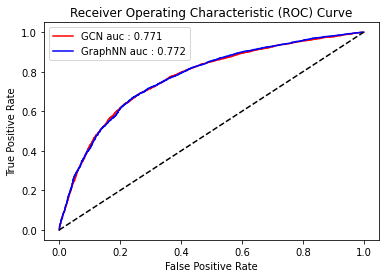

In [21]:
plt.plot(fpr1, tpr1, color = 'red', label = f'GCN auc : {area1:.3f}')
plt.plot(fpr2, tpr2, color = 'blue', label = f'GraphNN auc : {area2:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.savefig(f'roc_auc.png')
plt.show()